<a href="https://colab.research.google.com/github/SiddheshDaphane/Deep_Learning_With_PyTorch/blob/master/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch import nn # contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

### Data (preparing and loading)

In [13]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

### Split data into training and test sets

In [14]:
train_split = int(0.8 * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

In [15]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

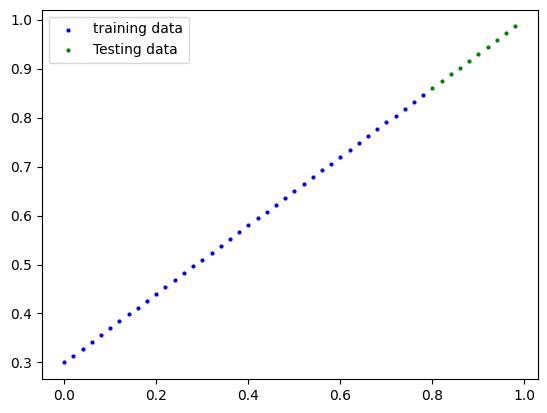

In [16]:
plt.scatter(X_train, y_train, c="b", s=4, label="training data")
plt.scatter(X_test, y_test, c="g", s=4, label = "Testing data")
plt.legend()
plt.show()

## Building a model

In [17]:
from torch import nn
import torch

In [7]:
# Create a Linear Regression model class

class LinearRegressionModel(nn.Module): # almost everything in PyTorch is a nn.Module meaning it is the base class
  def __init__(self):
    super().__init__() # Think of super().__init__() as a way to ensure your LinearRegressionModel gets all the capabilities of nn.Module.

    self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad= True, dtype= torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias



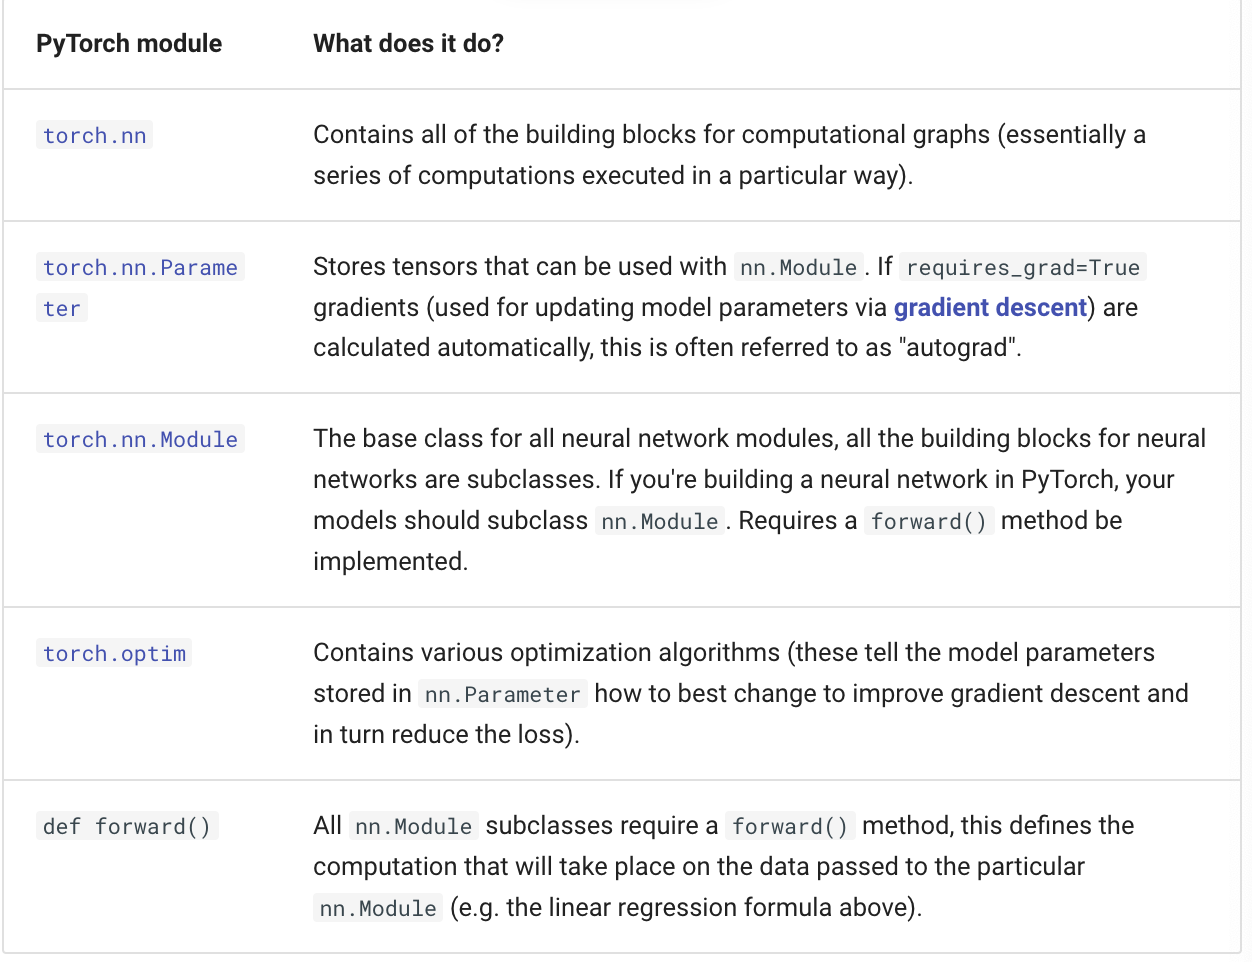

### Checking the contents of a PyTorch model

In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that conatins nn.Parameter)
model_0 = LinearRegressionModel()

# Check the nn.parameters within nn.Module subclass we created
model_0.parameters()

<generator object Module.parameters at 0x7bbb5552f3e0>

In [9]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bounch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster

In [18]:
with torch.inference_mode():
  y_pred = model_0(X_test)

#### Plotting preditions

In [20]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label= "testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size":14})


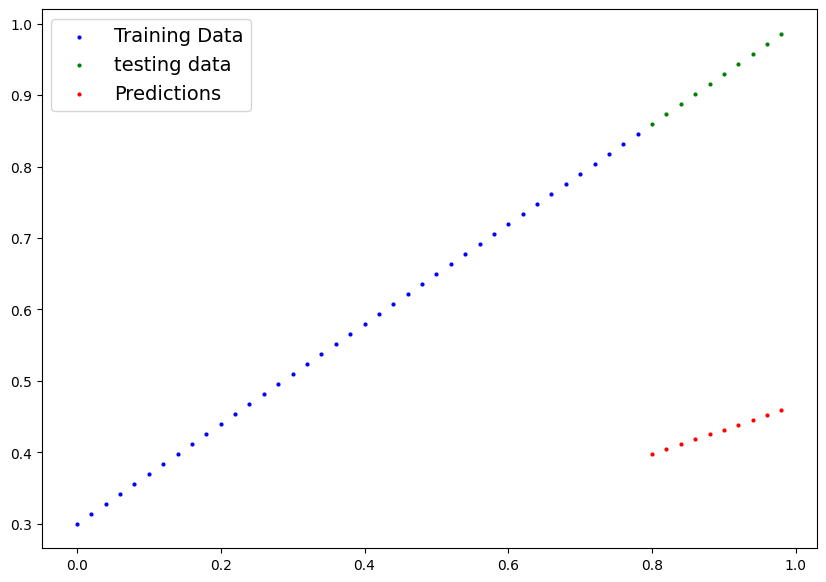

In [21]:
plot_predictions(predictions=y_pred)

## Train model

#### Creatingg a loss function and optimizer in PyTorch
For our model to upadate it's parameters on it'w own we need **Loss Fucntion** and **Optimizer**

* **Loss Function** :- Measures how wrong your model's predictions (e.g. `y_pred`) are compared to the truth labels (e.g. `y_test`). Lower the better

* **Optimizer** :- Tells your model how to update its internal parameters to best lower the loss

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01, 0.001, 0.0001`, however, these can also be adjusted over time (this is called learning rate scheduling).


In [22]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch
It's time to create a **training loop** (and **testing loop**)

The training loop involves the model going through the trainning data and learning the relationship between `features` and `labels`

The testing loop involves goimg through the testing data and evaluting how good the patterns are that the model learned on the training data (the model never see the testing data during training)

Each of these is called a "loop" beacuse we want our model to look (loop through) at each sample in each dataset

### PyTorch training loop

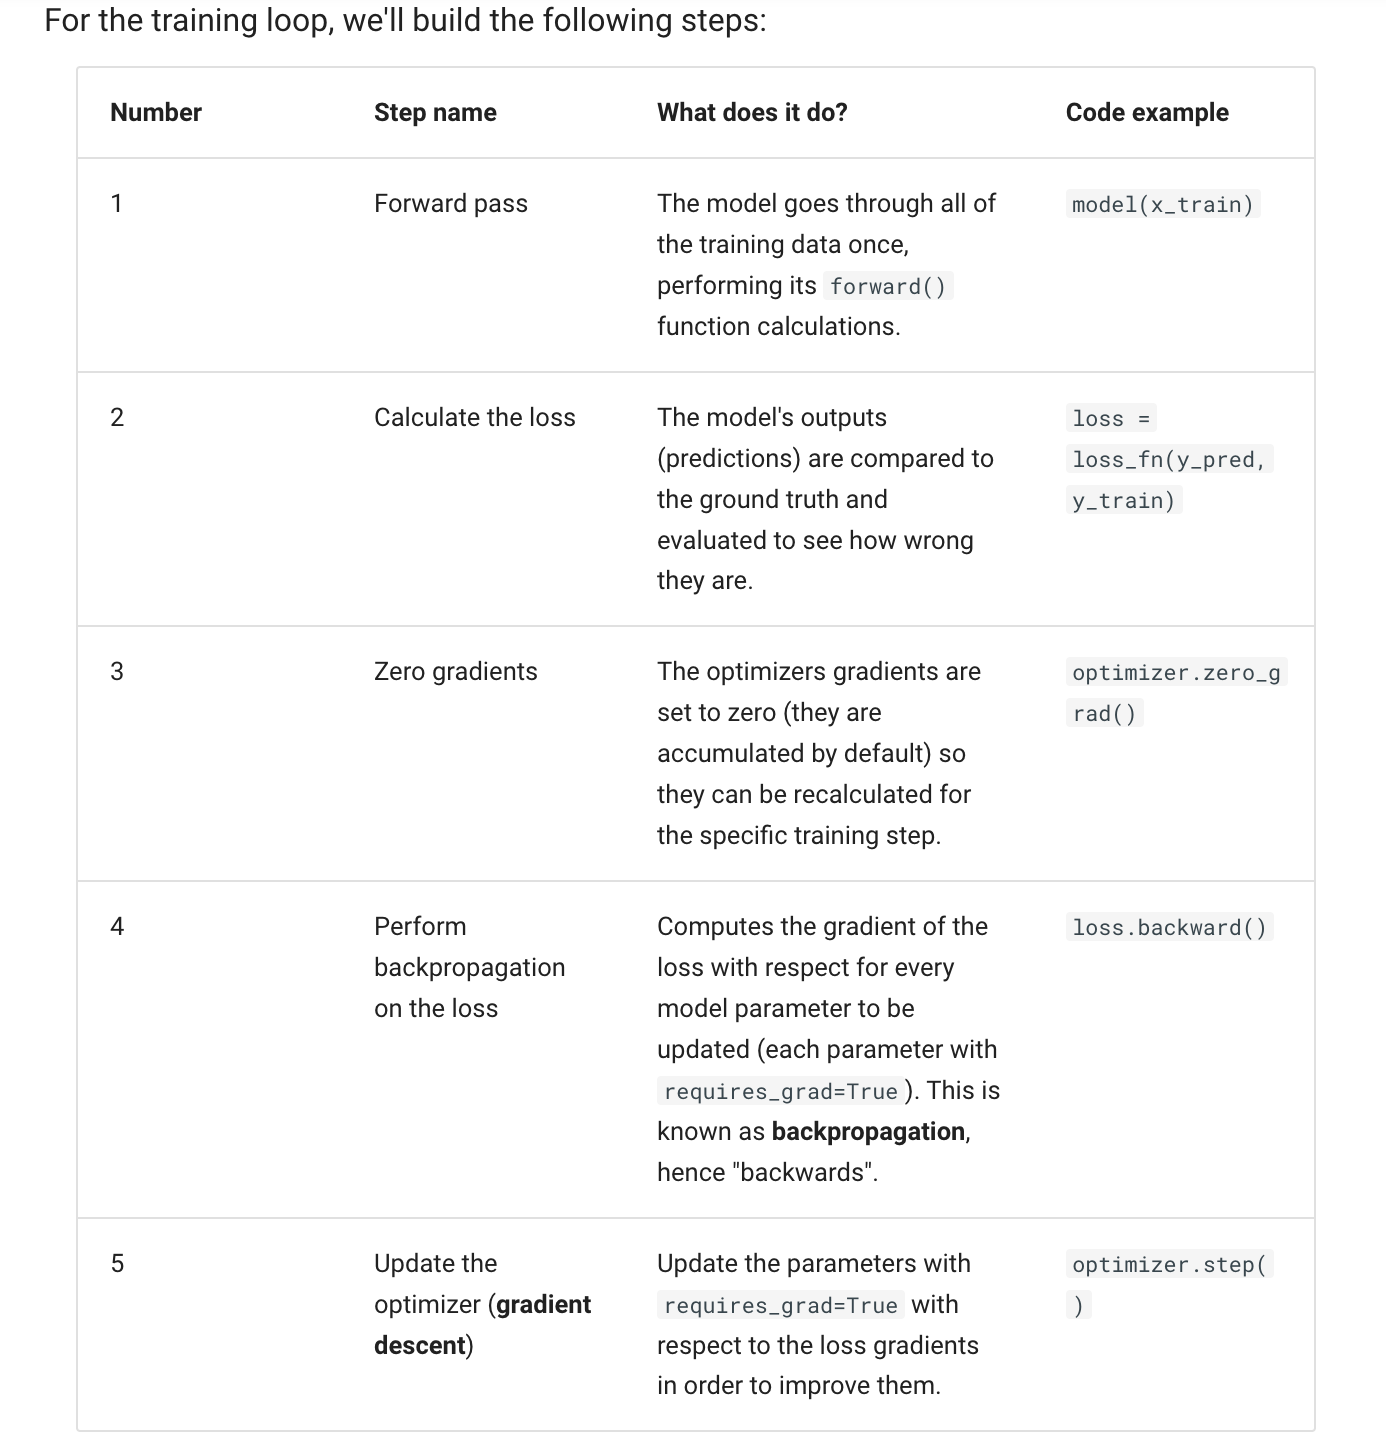